In [1]:
import nsepy as ns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from matplotlib import style
from datetime import date
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [3]:
pd.options.mode.chained_assignment = None
output_notebook()
style.use('ggplot')

Loading BokehJS ...

## Get Data

In [4]:
# get stock prices for nifty_it index from 1st Jan 2017 to 24th Oct, 2018
nifty_it = ns.get_history(symbol='NIFTY IT',
                    start=date(2017,1,1), 
                    end=date(2018,10,24), index=True)

In [5]:
nifty_it.index = pd.to_datetime(nifty_it.index)

In [6]:
nifty_it.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-15',
               '2018-10-16', '2018-10-17', '2018-10-19', '2018-10-22',
               '2018-10-23', '2018-10-24'],
              dtype='datetime64[ns]', name='Date', length=449, freq=None)

In [7]:
nifty_it.head()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2017-01-02,10403.00,10434.10,10353.65,10367.05,5366213.0,4.188400e+09
2017-01-03,10386.60,10390.90,10291.25,10362.25,8413396.0,7.458500e+09
2017-01-04,10368.15,10517.55,10364.00,10496.90,11978446.0,1.004990e+10
2017-01-05,10539.75,10590.05,10379.30,10400.05,23534557.0,1.569580e+10
2017-01-06,10352.80,10372.90,10063.35,10110.40,26296599.0,1.935410e+10


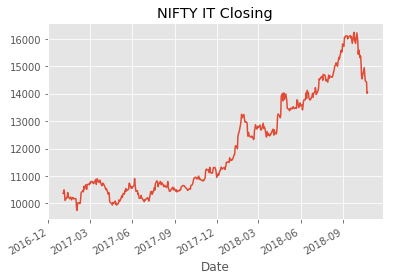

In [8]:
nifty_it['Close'].plot(title='NIFTY IT Closing')

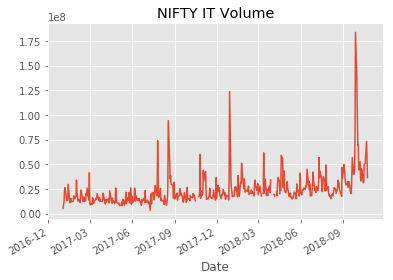

In [9]:
nifty_it['Volume'].plot(title='NIFTY IT Volume')

## Part 1: Moving Averages, Volume and Price Shocks

In [10]:
# computer 4,16, 28, 40, 52 week moving average
def add_moving_averages(stock_index):
    for i in range(4, 53, 12):
        weeks = i
        days = weeks * 7
        stock_index['MA_{}_weeks'.format(weeks)] = stock_index.Close.rolling(window=days, min_periods=0).mean()

In [11]:
nifty_it_closing = pd.DataFrame(nifty_it.Close)
add_moving_averages(nifty_it_closing)

In [12]:
nifty_it_closing.tail()

,Close,MA_4_weeks,MA_16_weeks,MA_28_weeks,MA_40_weeks,MA_52_weeks
Date,,,,,,
2018-10-17,14949.60,15697.462500,14623.650893,13826.401276,12964.025357,12387.362637
2018-10-19,14476.85,15641.639286,14633.447321,13841.067092,12978.177143,12399.301648
2018-10-22,14421.40,15582.344643,14642.090179,13855.529847,12992.390179,12411.155769
2018-10-23,14014.70,15507.700000,14647.334821,13867.896684,13004.949821,12421.948077
2018-10-24,14049.15,15434.266071,14652.429018,13880.221173,13017.905179,12432.497527


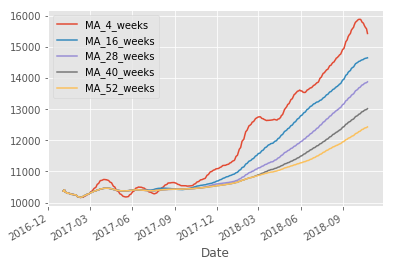

In [13]:
nifty_it_closing[['MA_4_weeks', 'MA_16_weeks', 'MA_28_weeks', 'MA_40_weeks' ,'MA_52_weeks']].plot()

In [14]:
# compute ohlc on a sample of 10 days
nifty_it_10_ohlc = nifty_it['Close'].resample('10D').ohlc()
nifty_it_10_ohlc.head()

,open,high,low,close
Date,,,,
2017-01-02,10367.05,10496.90,10110.40,10220.55
2017-01-12,10398.80,10398.80,10132.65,10132.65
2017-01-22,10219.40,10219.40,9848.50,9848.50
2017-02-01,9750.00,10387.85,9750.00,10387.85
2017-02-11,10452.90,10671.20,10427.65,10671.20


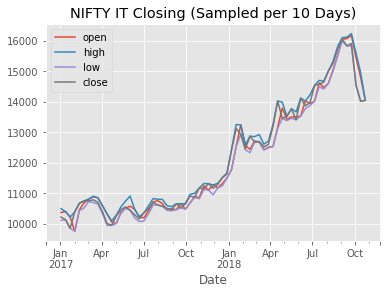

In [15]:
nifty_it_10_ohlc.plot(title='NIFTY IT Closing (Sampled per 10 Days)')

In [16]:
nifty_it['VolumeShock'] = pd.Series()
nifty_it['VolumeShock_dir'] = pd.Series()
nifty_it['PriceShock'] = pd.Series()
nifty_it['PriceShock_dir'] = pd.Series()
nifty_it['PriceShockWithoutVolumeShock'] = pd.Series()

In [17]:
for i in range(1, len(nifty_it.Volume)):
    # if volume traded is 10% higher than previous day 
    if nifty_it.Volume[i] > ( nifty_it.Volume[i - 1] + 0.1 * nifty_it.Volume[i - 1] ):
        nifty_it['VolumeShock'][i] = 1
        nifty_it['VolumeShock_dir'][i] = 1
    # if volume traded is 10% lower than previous day 
    elif nifty_it.Volume[i] < ( nifty_it.Volume[i - 1] - 0.1 * nifty_it.Volume[i - 1] ):
        nifty_it['VolumeShock'][i] = 1
        nifty_it['VolumeShock_dir'][i] = -1
    else:
        nifty_it['VolumeShock'][i] = 0
    
    # if closing price has a difference > 2%,
    if nifty_it.Close[i] > ( nifty_it.Close[i - 1] + 0.2 * nifty_it.Close[i - 1] ):
        nifty_it['PriceShock'][i] = 1
        nifty_it['PriceShock_dir'][i] = 1
    # if closing price has a difference < 2%,
    elif nifty_it.Close[i] < ( nifty_it.Close[i - 1] - 0.2 * nifty_it.Close[i - 1] ):
        nifty_it['PriceShock'][i] = 1
        nifty_it['PriceShock_dir'][i] = -1
    else:
        nifty_it['PriceShock'][i] = 0
    
    # if price shock but no volume shock
    if nifty_it['PriceShock'][i] == 1 and nifty_it['VolumeShock'][i] == 0:
        nifty_it['PriceShockWithoutVolumeShock'] = 1
    else:
        nifty_it['PriceShockWithoutVolumeShock'] = 0

In [18]:
nifty_it.head(20)

,Open,High,Low,Close,Volume,Turnover,VolumeShock,VolumeShock_dir,PriceShock,PriceShock_dir,PriceShockWithoutVolumeShock
Date,,,,,,,,,,,
2017-01-02,10403.00,10434.10,10353.65,10367.05,5366213.0,4.188400e+09,NaN,NaN,NaN,NaN,0
2017-01-03,10386.60,10390.90,10291.25,10362.25,8413396.0,7.458500e+09,1.0,1.0,0.0,NaN,0
2017-01-04,10368.15,10517.55,10364.00,10496.90,11978446.0,1.004990e+10,1.0,1.0,0.0,NaN,0
2017-01-05,10539.75,10590.05,10379.30,10400.05,23534557.0,1.569580e+10,1.0,1.0,0.0,NaN,0
2017-01-06,10352.80,10372.90,10063.35,10110.40,26296599.0,1.935410e+10,1.0,1.0,0.0,NaN,0
2017-01-09,10070.65,10214.20,10023.65,10198.45,17060520.0,1.250980e+10,1.0,-1.0,0.0,NaN,0
2017-01-10,10232.55,10255.85,10184.35,10221.50,13114211.0,1.116940e+10,1.0,-1.0,0.0,NaN,0
2017-01-11,10238.05,10282.20,10154.50,10220.55,14041555.0,1.186470e+10,0.0,NaN,0.0,NaN,0
2017-01-12,10237.45,10410.80,10236.00,10398.80,14364865.0,1.296400e+10,0.0,NaN,0.0,NaN,0


## Part 2: Data Visualization

In [19]:
p = figure(x_axis_type="datetime", width=500, height=500, title="NIFTY IT Index - ClosingPrice", x_axis_label = 'Date', y_axis_label = 'Closing Price')
p.circle(pd.to_datetime(nifty_it.index), nifty_it.Close, size=7, color="blue", alpha=0.5)
show(p)

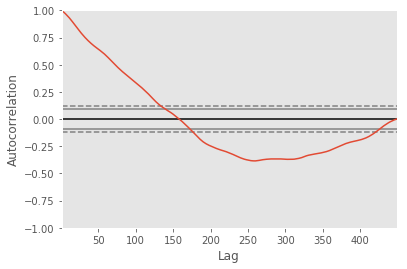

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nifty_it.Close)

*Fig: Auto correlation plot for NIFTY IT Index (Closing Price)*

**As the no of days increase we see the correlation become less eventually reaching close to 0 which is to be expected as current Closing Stock price isn't just dependent on the past Closing Stock Price.**

## Part 3 - Data Modelling

In [21]:
# stock info for infosys 2015-2016
company_stock = 'INFY'
start_date = date(2015, 1, 1)
end_date = date(2018, 10, 25)
nifty_it = ns.get_history(symbol='NIFTY IT',
                    start=start_date, 
                    end=end_date, index=True)
infy_stock = ns.get_history(symbol=company_stock,
                    start=start_date, 
                    end=end_date)

In [22]:
infy_stock.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2018-10-19,INFY,EQ,705.35,687.00,687.70,678.00,683.50,683.55,682.35,10421001,7.110757e+14,245258,6658247,0.6389
2018-10-22,INFY,EQ,683.55,688.70,695.05,673.80,680.50,679.95,679.08,6672840,4.531381e+14,118989,4592757,0.6883
2018-10-23,INFY,EQ,679.95,675.95,682.00,653.30,663.05,657.60,663.77,9041701,6.001591e+14,206699,6249984,0.6912
2018-10-24,INFY,EQ,657.60,663.00,666.50,647.15,650.00,649.80,653.45,7058164,4.612127e+14,151398,4319821,0.6120
2018-10-25,INFY,EQ,649.80,643.00,656.35,636.25,647.30,648.75,647.53,8270469,5.355339e+14,196622,5315499,0.6427


In [23]:
nifty_it['Prev Close'] = pd.Series()
for i in range(1, len(nifty_it)):
    nifty_it['Prev Close'][i] = nifty_it['Close'][i-1]
nifty_it.head()

,Open,High,Low,Close,Volume,Turnover,Prev Close
Date,,,,,,,
2015-01-01,11214.80,11235.75,11166.35,11215.70,4246150.0,3.575100e+09,NaN
2015-01-02,11214.65,11399.10,11214.65,11372.10,10004862.0,9.645600e+09,11215.70
2015-01-05,11369.35,11433.75,11186.95,11248.55,8858018.0,1.059000e+10,11372.10
2015-01-06,11186.10,11186.10,10909.00,10959.90,12515739.0,1.364500e+10,11248.55
2015-01-07,11013.20,11042.35,10889.55,10916.00,10976356.0,1.203440e+10,10959.90


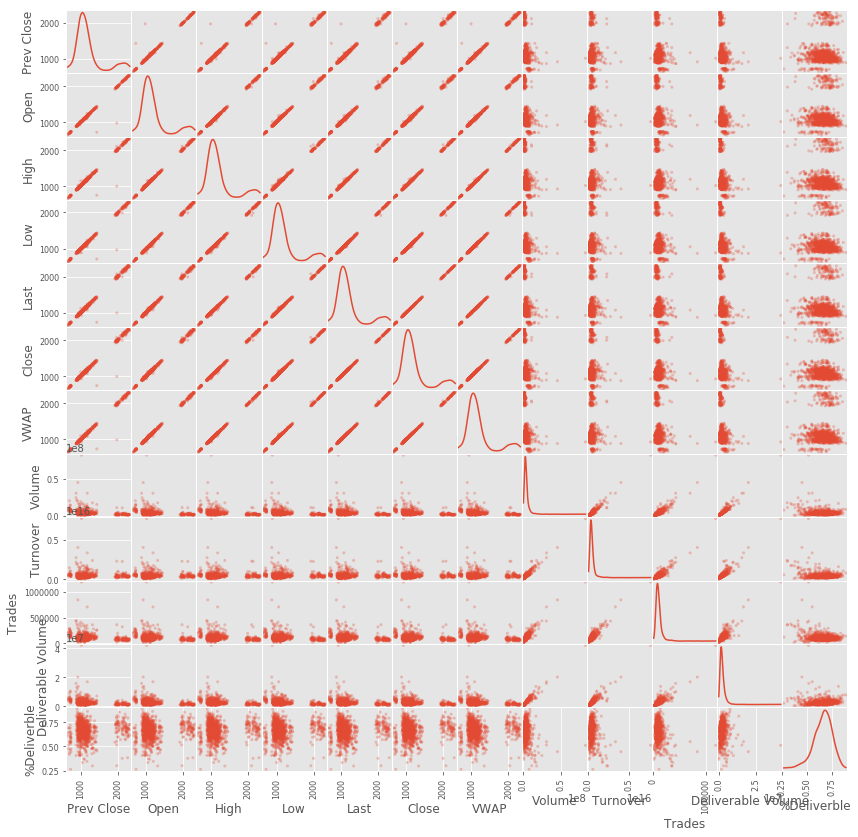

In [24]:
_=pd.plotting.scatter_matrix(infy_stock, alpha = 0.3, figsize = (14, 14), diagonal = 'kde')

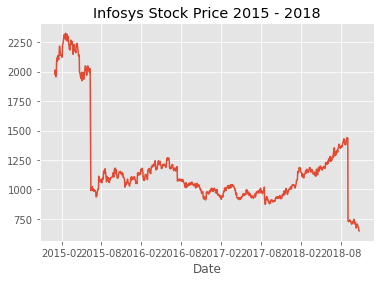

In [25]:
infy_stock['Close'].plot(title='Infosys Stock Price 2015 - 2018')

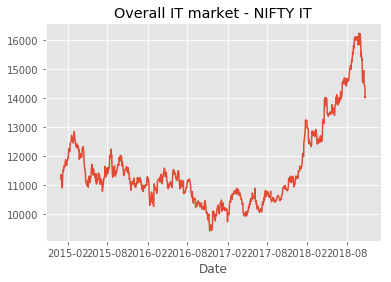

In [26]:
nifty_it['Close'].plot(title='Overall IT market - NIFTY IT')

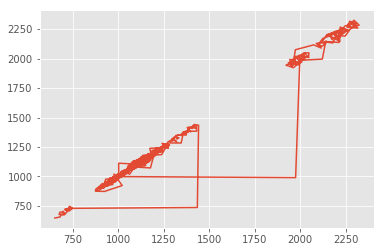

In [27]:
plt.plot(infy_stock['Prev Close'].values, infy_stock['Close'].values)

**This plot shows a clear relationship between previous day's closing price and today's closing price**

**We will take day, month and previous days stock price to predict the next day's stock price**

In [28]:
# Data Preprocessing and feature engineering
stock_day = [date.day for date in infy_stock.index.values]
stock_month = [date.month for date in infy_stock.index.values]
stock_prev_close = infy_stock['Prev Close'].values.reshape(1, -1)
stock_price = infy_stock.Close.values

In [29]:
# stack all three features together
X = np.dstack((stock_day, stock_month, stock_prev_close))[0]
y = stock_price

In [30]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [31]:
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
linear_model = LinearRegression()

In [32]:
svr.fit(X, y)
linear_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Next Day Stock Price Prediction** 

In [33]:
svm_next_day_closing_price = svr.predict([[X[-1][0]+1, X[-1][1], X[-1][2]]])[0]
lm_next_day_closing_price = linear_model.predict([[X[-1][0]+1, X[-1][1], X[-1][2]]])[0]
print('SVM Model predicted closing price for tommorow as: {:.2f}'.format(svm_next_day_closing_price))
print('Linear Regression Model predicted closing price for tommorow as: {:.2f}'.format(lm_next_day_closing_price))

SVM Model predicted closing price for tommorow as: 705.31
Linear Regression Model predicted closing price for tommorow as: 653.18


### Stock Price Prediction for next 10 days

In [34]:
import datetime
svm_pred_prev_close = lm_pred_prev_close = X[-1][2]
day = X[-1][0]
month = X[-1][1]
year = 2018
for i in range(1, 11): 
    dt = date(year, int(month), int(day))
    dt += datetime.timedelta(days=i) 
    svm_next_day_closing_price = svr.predict([[dt.day,dt.month, svm_pred_prev_close]])[0]
    svm_pred_prev_close = svm_next_day_closing_price
    lm_next_day_closing_price = linear_model.predict([[dt.day, dt.month, lm_pred_prev_close]])[0]
    lm_pred_prev_close = lm_next_day_closing_price
    print('SVM Model predicted closing price for {}-{}-{} as: {:.2f}'.format(dt.day, dt.month, dt.year, svm_next_day_closing_price))
    print('LRM Model predicted closing price for {}-{}-{} as: {:.2f}'.format(dt.day, dt.month, dt.year, lm_next_day_closing_price))
    print()

SVM Model predicted closing price for 26-10-2018 as: 705.31
LRM Model predicted closing price for 26-10-2018 as: 653.18

SVM Model predicted closing price for 27-10-2018 as: 1061.44
LRM Model predicted closing price for 27-10-2018 as: 656.69

SVM Model predicted closing price for 28-10-2018 as: 1181.04
LRM Model predicted closing price for 28-10-2018 as: 660.33

SVM Model predicted closing price for 29-10-2018 as: 1238.01
LRM Model predicted closing price for 29-10-2018 as: 664.09

SVM Model predicted closing price for 30-10-2018 as: 1239.78
LRM Model predicted closing price for 30-10-2018 as: 667.98

SVM Model predicted closing price for 31-10-2018 as: 1239.74
LRM Model predicted closing price for 31-10-2018 as: 671.99

SVM Model predicted closing price for 1-11-2018 as: 1239.41
LRM Model predicted closing price for 1-11-2018 as: 670.20

SVM Model predicted closing price for 2-11-2018 as: 1238.91
LRM Model predicted closing price for 2-11-2018 as: 668.61

SVM Model predicted closing p